In [1]:
import os
import warnings
from parmed.exceptions import GromacsWarning
warnings.simplefilter("ignore", GromacsWarning)
warnings.simplefilter("ignore", UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import mbuild as mb
import metamds as mds
import mdtraj as md

import nglview
from ipywidgets.widgets import Box

%matplotlib inline
!rm -rf output/ *.top *.gro

/Users/sallai/anaconda/envs/imodels/lib/python2.7/site-packages/jupyter_core/application.py:106: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  help="""Generate default config file."""
/Users/sallai/anaconda/envs/imodels/lib/python2.7/site-packages/jupyter_core/application.py:110: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  help="Specify a config file to load."
/Users/sallai/anaconda/envs/imodels/lib/python2.7/site-packages/jupyter_core/application.py:118: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  help="""Full path of a config file.""",
/Users/sallai/anaconda/envs/imodels/lib/python2.7/site-packages/jupyter

In [2]:
def build_monolayer(chain_length, n_molecules, **kwargs):
    from mbuild.examples import AlkaneMonolayer
    pattern = mb.Random2DPattern(n_molecules)
    monolayer = AlkaneMonolayer(pattern, tile_x=1, tile_y=1, 
                                chain_length=chain_length)
    mb.translate(monolayer, [0, 0, 2])
    return monolayer

In [3]:
def create_run_script(build_func, forcefield, input_dir, **kwargs):
    compound = build_func(**kwargs)
    name = compound.name
    em = os.path.join(input_dir, 'em.mdp')
    nvt = os.path.join(input_dir, 'nvt.mdp')
    gro = '{name}.gro'.format(name=name)
    top = '{name}.top'.format(name=name)

    box = compound.boundingbox
    compound.periodicity += np.array([0, 0, 5 * box.lengths[2]])
    compound.save(top, forcefield=forcefield, overwrite=True)

    em_grompp = 'gmx grompp -f {mdp} -c {gro} -p {top} -o em.tpr'.format(mdp=em, gro=gro, top=top)
    em_mdrun = 'gmx mdrun -v -deffnm em -ntmpi 1'

    nvt_grompp = 'gmx grompp -f {mdp} -c em.gro -p {top} -o nvt.tpr'.format(mdp=nvt, top=top)
    nvt_mdrun = 'gmx mdrun -v -deffnm nvt -ntmpi 1'

    script = (em_grompp, em_mdrun, nvt_grompp, nvt_mdrun)
    return script

In [4]:
# Initialize simulation with a template and some metadata
sim = mds.Simulation(name='monolayer', 
                     template=create_run_script, 
                     output_dir='output')

chain_lengths = [8, 12, 16, 20]
for length in chain_lengths:
    parameters = {'chain_length': length,
                  'n_molecules': 100,
                  'forcefield': 'OPLS-aa',
                  'build_func': build_monolayer}
    # Parameterize our simulation template
    sim.parametrize(**parameters)

In [5]:
# Run
sim.execute_all(hostname='rahman.vuse.vanderbilt.edu', username='sallai')

DEBUG:monolayer_debug:rsync -r -h --progress --partial /Users/sallai/PycharmProjects/demos/demos/monolayer/em.mdp /Users/sallai/PycharmProjects/demos/demos/monolayer/nvt.mdp /Users/sallai/PycharmProjects/demos/demos/monolayer/oplsaa.ff sallai@rahman.vuse.vanderbilt.edu:/raid6/homes/sallai/tmp.xZfNjszMtB
DEBUG:monolayer_debug:sending incremental file list
DEBUG:monolayer_debug:em.mdp
DEBUG:monolayer_debug:
DEBUG:monolayer_debug:            853 100%    0.00kB/s    0:00:00  
DEBUG:monolayer_debug:            853 100%    0.00kB/s    0:00:00 (xfr#1, to-chk=27/28)
DEBUG:monolayer_debug:nvt.mdp
DEBUG:monolayer_debug:
DEBUG:monolayer_debug:            534 100%  521.48kB/s    0:00:00  
DEBUG:monolayer_debug:            534 100%  521.48kB/s    0:00:00 (xfr#2, to-chk=26/28)
DEBUG:monolayer_debug:oplsaa.ff/
DEBUG:monolayer_debug:oplsaa.ff/1propanol.itp
DEBUG:monolayer_debug:
DEBUG:monolayer_debug:          2.01K 100%    1.92MB/s    0:00:00  
DEBUG:monolayer_debug:          2.01K 100%    1.92MB/s  

In [6]:
sim.sync_all()

DEBUG:monolayer_debug:rsync -r -h --progress --partial sallai@rahman.vuse.vanderbilt.edu:/raid6/homes/sallai/tmp.xZfNjszMtB/output/task_0/* /Users/sallai/PycharmProjects/demos/demos/monolayer/output/task_0
DEBUG:monolayer_debug:receiving incremental file list
DEBUG:monolayer_debug:skipping non-regular file "em.mdp"
DEBUG:monolayer_debug:skipping non-regular file "nvt.mdp"
DEBUG:monolayer_debug:skipping non-regular file "oplsaa.ff"
DEBUG:monolayer_debug:#mdout.mdp.1#
DEBUG:monolayer_debug:
DEBUG:monolayer_debug:              0   0%    0.00kB/s    0:00:00  
DEBUG:monolayer_debug:         11.63K 100%   11.09MB/s    0:00:00 (xfr#1, to-chk=16/17)
DEBUG:monolayer_debug:AlkaneMonolayer.gro
DEBUG:monolayer_debug:
DEBUG:monolayer_debug:              0   0%    0.00kB/s    0:00:00  
DEBUG:monolayer_debug:        216.08K 100%    5.03MB/s    0:00:00 (xfr#2, to-chk=15/17)
DEBUG:monolayer_debug:AlkaneMonolayer.top
DEBUG:monolayer_debug:
DEBUG:monolayer_debug:              0   0%    0.00kB/s    0:00:0

In [7]:
task_1 = next(sim.tasks())
trj_path = os.path.join(task_1.output_dir, 'nvt.xtc')
top_path = os.path.join(task_1.output_dir, 'em.gro')
traj = md.load(trj_path, top=top_path)
print(traj)

<mdtraj.Trajectory with 28 frames, 4800 atoms, 1 residues, and unitcells>


In [11]:
t = nglview.MDTrajTrajectory(traj)
w = nglview.NGLWidget(t)
w.representations = [{'type':'ball+stick'}]
Box(children=(w,))

/Users/sallai/anaconda/envs/imodels/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:157: DeprecationWarning: Widget._keys_default is deprecated: use @default decorator instead.
  def _keys_default(self):
/Users/sallai/anaconda/envs/imodels/lib/python2.7/site-packages/ipywidgets/widgets/widget.py:157: DeprecationWarning: Widget._keys_default is deprecated: use @default decorator instead.
  def _keys_default(self):
/Users/sallai/anaconda/envs/imodels/lib/python2.7/site-packages/ipykernel/comm/comm.py:52: DeprecationWarning: Comm._comm_id_default is deprecated: use @default decorator instead.
  def _comm_id_default(self):
/Users/sallai/anaconda/envs/imodels/lib/python2.7/site-packages/ipykernel/comm/comm.py:29: DeprecationWarning: Comm._iopub_socket_default is deprecated: use @default decorator instead.
  def _iopub_socket_default(self):
/Users/sallai/anaconda/envs/imodels/lib/python2.7/site-packages/ipykernel/comm/comm.py:24: DeprecationWarning: Comm._kernel_default is deprecate

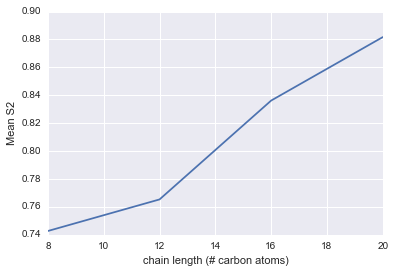

In [12]:
average_S2 = list()
for task in sim.tasks():
    # Load up the trajectory
    trj_path = os.path.join(task.output_dir, 'nvt.xtc')
    top_path = os.path.join(task.output_dir, 'em.gro')
    traj = md.load(trj_path, top=top_path)
    
    # Nematic order parameter
    atoms_per_chain = int((traj.n_atoms - 1800) / 100)
    chain_indices = [[n+x for x in range(atoms_per_chain)] 
                     for n in range(1800, traj.n_atoms, atoms_per_chain)]
    s2 = md.compute_nematic_order(traj, indices=chain_indices)
    average_S2.append(np.mean(s2))
    
    
plt.plot(chain_lengths, average_S2)
plt.xlabel('chain length (# carbon atoms)')
plt.ylabel('Mean S2')